In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import sqlite3

In [2]:
database = "data.sqlite"

conn = sqlite3.connect(database)

train_df = pd.read_sql("select * from new_table_name", con=conn)
train_df.head()

,Unnamed: 0,year,make,model,final_price,mileage,engine,zipcode
0,1,1997,Chevrolet,Chevrolet Suburban,"$17,000",67000,5.7L Vortec V8,60069
1,2,1990,Porsche,Porsche 964 911,"$225,000",1000,3.8-Liter Flat-Six,84790
2,3,2003,Toyota,Toyota Pickup,"$24,750",116000,3.4-Liter DOHC V6,90027
3,5,1992,Volkswagen,Volkswagen Golf/Rabbit Cabriolet,"$10,750",100000,1.8-Liter Inline-Four,98208
4,6,2008,Toyota,Toyota FJ Cruiser,"$32,500",9000,4.0-Liter V6,57108


In [3]:
conn.close()

In [4]:
train_df.dtypes

Unnamed: 0      int64
year            int64
make           object
model          object
final_price    object
mileage         int64
engine         object
zipcode         int64
dtype: object

In [5]:
train_df = train_df[train_df.year <= 2200]
train_df = train_df[train_df.mileage <= 300000]

In [6]:
train_df['final_price']=(train_df['final_price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [7]:
train_df.dtypes

Unnamed: 0       int64
year             int64
make            object
model           object
final_price    float64
mileage          int64
engine          object
zipcode          int64
dtype: object

In [8]:
train_X = train_df.drop(columns='final_price')
train_y = train_df['final_price']

train_df.plot(
   x='mileage', 
   y=train_y, 
   kind='scatter'
)

plt.show()

In [9]:
# Convert categorical data to numeric and separate target feature for training data
train_df1 = pd.get_dummies(train_X)
train_df1.head()

,Unnamed: 0,year,mileage,zipcode,make_000s,make_020s,make_940s,make_950s,make_960s,make_970s,...,engine_Twin-Turbocharged 6.0-Liter V12,engine_Twin-Turbocharged 6.0-Liter W12,engine_Twin-Turbocharged EcoBoost 2.7L V6,engine_Twin-turbocharged 3.6L Flat-Six,engine_VIP Parking,engine_Whipple-Supercharged 5.4-Liter V8,"engine_XPAG 1,250cc Inline-Four",engine_XPAG Inline-Four,engine_Yellow & Black Paint,engine_Z/28 Equipment Package
0,1,1997,67000,60069,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1990,1000,84790,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2003,116000,90027,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,1992,100000,98208,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,2008,9000,57108,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train_y.dtypes

dtype('float64')

In [11]:
model = LinearRegression()
model.fit(train_df1, train_y)
print(f'Model Score: {model.score(train_df1, train_y)}')

Model Score: 0.968095314211466


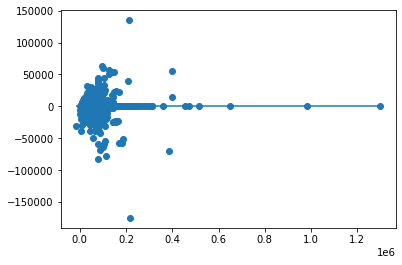

In [12]:
predictions = model.predict(train_df1)
# Plot Residuals
plt.scatter(predictions, predictions - train_y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [14]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(f"True output: {train_y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-train_y[0]}")

Weight coefficients:  [-2.98276978e-01  9.35597292e+02 -7.32618400e-02 ...  1.19243041e+09
  3.71564854e+10 -1.29223745e+09]
y-axis intercept:  -37158307115.839554
True output: 17000.0
Predicted output: 17000.94451904297
Prediction Error: 0.94451904296875


In [16]:
# x_min = train_df1.min()
# x_max = train_df1.max()
# y_min_actual = train_y.min()
# y_max_actual = train_y.max()

# y_min = 101.896225057 + (model.coef_ * x_min)
# y_max = 101.896225057 + (model.coef_ * x_max)
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Calculated Min Value: {y_min}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Calculated Max Value: {y_max}")

# y_min_predicted = model.predict([[x_min]])
# y_max_predicted = model.predict([[x_max]])
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Predicted Min Value: {y_min_predicted}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Predicted Max Value: {y_max_predicted}")

# plt.scatter(X, y, c='blue')
# plt.plot([x_min, x_max], [y_min, y_max], c='red')